# **🧢Transformer Model**

* **Seq2Seq** 모델과 같이 인코더와 디코더로 구성됨.
* **Seq2Seq** 모델에서 사용한 순환 신경망을 사용하지 않고, **Self Attention** 기법을 사용하여 문장에 대한 정보를 추출함.

<img src="./image/transformer_all.png" width="600" height="600">

In [8]:
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from word_preprocess import * 

## 🌈**Self-Attention**

* 문장에서 각 단어끼리 얼마나 관계가 있는지를 계산해서 반영하는 방법.
  - 문장 : **['딥러닝', '자연어', '처리', '아주', '좋아요']**

* **Attension score**
  - 각 단어('딥러닝')를 기준으로 다른 단어들과의 관계 값을 계산
  - 트렌스포머 모델에서는 단어 벡터끼리 내적 연산을 통해 Attention score를 구함.
    - $attention\_score_{q(딥러닝)\_k(딥러닝)} = vector_{q(딥러닝)} * vector_{k(딥러닝)} = 25$
    - $attention\_score_{q(딥러닝)\_k(자연어)} = vector_{q(딥러닝)} * vector_{k(자연어)} = 25$
    - $attention\_score_{q(딥러닝)\_k(처리)} = vector_{q(딥러닝)} * vector_{k(처리)} = 24.3$
    - $attention\_score_{q(딥러닝)\_k(아주)} = vector_{q(딥러닝)} * vector_{k(아주)} = 24.3$
    - $attention\_score_{q(딥러닝)\_k(좋아요)} = vector_{q(딥러닝)} * vector_{k(좋아요)} = 24$

* **Attension map**
  - 각 단어들의 attention score를 하나의 테이블로 만든 것을 Attention map 이라고 함.
  - Attention map에 softmax함수를 취해서, 특정 단어('딥러닝')에 대해 다른 단어들의 연관정도가 확률로 나타남.
    - $attention\;map = [25, 25, 24.3, 24.3, 24]$
    - $softmax(attention\;map) = [0.3, 0.3, 0.15, 0.15, 0.1]$


* **Context vector**
  - 각 단어 벡터들에 대해서 attention score값을 곱해주고 더해주는 weighted sum 연산을 통해 단어 '딥러닝'의 Context vector를 구해줌.
    - $context\_vector_{q(딥러닝)} = softmax(attention\_score_{q(딥러닝)\_k(딥러닝)}*vector_{v(딥러닝)}$
    - $\qquad \qquad \qquad \qquad \qquad + softmax(attention\_score_{q(딥러닝)\_k(자연어)})*vector_{v(자연어)}$
    - $\qquad \qquad \qquad \qquad \quad + softmax(attention\_score_{q(딥러닝)\_k(처리)})*vector_{v(처리)}$
    - $\qquad \qquad \qquad \qquad \quad + softmax(attention\_score_{q(딥러닝)\_k(아주)})*vector_{v(아주)}$
    - $\qquad \qquad \qquad \qquad \qquad + softmax(attention\_score_{q(딥러닝)\_k(좋아요)})*vector_{v(좋아요)}$


## 🌈**scaled dot product attention**

* **self attention 방식**을 기반으로 구성됨. 내적 어텐션 구조가 중첩된 형태.
* **내적 어텐션, 순방향 어텐션 마스크, 멀티 헤드 어텐션**
  * $Attention(Q,K,V)=softmax\left (\frac{QK^{T}}{\sqrt{d_{k}}}  \right )V$
  * $One\; query\;:\;Q_{(1\times n)}, K_{(1\times n)}, V_{(1\times n)}, Attention(Q,K,V)_{(1\times n)},d_{k}=n$
  * $All\; query\;:\;Q_{(m\times n)}, K_{(m\times n)}, V_{(m\times n)}, Attention(Q,K,V)_{(m\times n)},d_{k}=n$

* quert와 value를 이용해 내적한 값이 벡터의 차원이 커지면 학습이 잘 안될 수 있기 때문에 벡터의 크기에 반비례하도록 크기를 조정 $d_{k}$.

In [9]:
def scaled_dot_product_attention(q, k, v, mask) :
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk/tf.math.sqrt(dk)

    if mask is not None :
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

## 🌈 **Subsequent Masked Attention(순방향 마스크 어텐션)**
- seq2seq 모델은 스텝이 존재해서 각 스텝마다 단어가 입력으로 들어가는 구조이지만
- transformer 모델은 전체 문장이 한번에 행렬 형태로 입력되는 구조이며 이런 부분이 문제가 될 수 있다.
    - 예를 들어, 문장을 예측하는 과정에서 디코더 부분에 입력이 들어갈 텐데 순환 신경망 구조의 경우 자신보다 앞에 있는 단어만 참고해서 단어를 예측한다.
    - 하지만, 트랜스포머의 경우 전체 문장이 들어가기 때문에 위치와 상관없이 모든 단어를 참고해 예측하는 문제가 발생.
    - 이러한 문제를 해결하기 위해 자신보다 뒤에 있는 단어들은 참고하지 않게 하는 기법이 **mask**기법이다.

In [10]:
import tensorflow as tf
mask = 1 - tf.linalg.band_part(tf.ones((5, 8)), -1, 0)
mask*-100

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[  -0., -100., -100., -100., -100., -100., -100., -100.],
       [  -0.,   -0., -100., -100., -100., -100., -100., -100.],
       [  -0.,   -0.,   -0., -100., -100., -100., -100., -100.],
       [  -0.,   -0.,   -0.,   -0., -100., -100., -100., -100.],
       [  -0.,   -0.,   -0.,   -0.,   -0., -100., -100., -100.]],
      dtype=float32)>

In [11]:
def create_look_ahead_mask(size) :
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [12]:
def create_padding_mask(seq) :
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch, 1, 1 ,seq_len)

In [13]:
def create_masks(inp, tar) :
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in Decoder's 2nd attention block
    dec_padding_mask = create_padding_mask(inp)

    # Used in Decoder's 1st attention block
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask 

## 🌈**Multi-Head Attention**

* 여러 개의 Scaled Dot-Product Attention들을 통해 다양한 context를 읽은 뒤 합치는 방식을 Multi-head Attention이라고 함.
1. query, key, value에 대한 feature를 head 수 만큼 나눔
2. 각각의 head에 대해 Linear Layer를 거침.
3. 각각의 Linear Layer 출력값에 대해 Scaled Dot-Product Attention을 구함.
4. 합쳐서 Multi-Head Attention 값을 구함

In [14]:
class MultiHeadAttention(tf.keras.layers.Layer) :
    def __init__(self, **kargs) :
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']
        
        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])
        
        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size) :
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask) :
        batch_size = tf.shape(q)[0]

        q = self.wq(q) # (batch_size, seq_len, d_model)
        k = self.wk(k) # (batch_size, seq_len, d_model)
        v = self.wv(v) # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size) # (batch_size, num_head, seq_len, depth)
        k = self.split_heads(k, batch_size) # (batch_size, num_head, seq_len, depth)
        v = self.split_heads(v, batch_size) # (batch_size, num_head, seq_len, depth)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)   # (batch_size, num_head, seq_len, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])                # (batch_size, seq_len, num_head, depth) 
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))     # (batch_size, seq_len, d_model)
        output = self.dense(concat_attention)

        return output, attention_weights


## 🌈**Position-wise feed forward network**

* transformer model은 self-attention layer에서 출력된 값을 feed forward network를 거침

$$
FFN(x) = max(0, xW_{1} + b_{1})W_{2} + b_{2}

$$

In [15]:
def point_wise_feed_forward_network(**kargs) :
    return tf.keras.Sequential([tf.keras.layers.Dense(kargs['dff'], activation='relu'),
                                tf.keras.layers.Dense(kargs['d_model'])])

## 🌈**Residual connection**

* transformer model은 residual connection을 한 다음, 레이어에 대한 값을 Normalization하는 Layer Normalization을 수행함.

**Encoder Layer**

* 아래 코드는 Encoder Layer에서 Residual Connection을 구현한 모습.
* Transformer 전체 구조의 **Add&Norm**에 해당되는 부분으로 자주 사용된다.
```python

self.ffn = point_wise_feed_forward_network(**kargs)
self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

ffn_output = self.ffn(out1)
ffn_output = self.dropout2(ffn_output)
out2 = self.layernorm2(out1 + ffn_output)
```

## 🌈**Positional-Encoding**

* transformer model은 입력 데이터를 순차적으로 제공하는 것이 아니라 한번에 입력해주기 때문에 입력 시퀀스에 대한 정보를 추가로 넣어줘야 함.
* **"Positional Encoding"** 은 트렌스포머 모델에 입력값의 순서 정보를 입력해주기 위해 사용한 방법.

$$
PE_{(pos,2i)}=\sin \left ( pos/10000^{2i/d_{model}} \right ) \\
PE_{(pos,2i+1)}=\cos \left ( pos/10000^{2i/d_{model}} \right )
$$

* 각 단어를 Embedding 했을 때 embedding된 데이터의 feature 인덱스가 짝수인 경우 $cos$ 함수 할당.
* 각 단어를 Embedding 했을 때 embedding된 데이터의 feature 인덱스가 홀수인 경우 $sin$ 함수 할당.

* 입력 단어의 순서는 $pos$에 반영 됨
* 뒷 부분은 생각 해보자



In [16]:
def get_angles(pos, i, d_model) :
    angle_rates = 1 / np.power(10000, (2*i//2)/np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model) :
    angle_rads = get_angles(pos = np.arange(position)[:, np.newaxis],
                            i = np.arange(d_model)[np.newaxis, :],
                            d_model = d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

**positional encoding example**

* position = 25  : 최대 입력 단어
* d_model = 64   : 각 단어 embedding 차원

shape of pos : (25, 1)
shape of i : (1, 64)
shape of angle_rads : (25, 64)
shape of pos_encoding : (1, 25, 64)


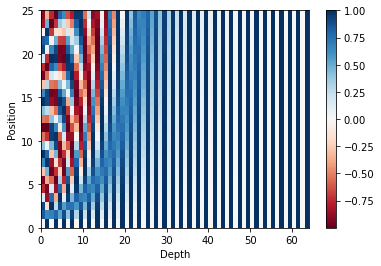

In [17]:
position = 25
d_model = 64
pos = np.arange(position)[:, np.newaxis]
i = np.arange(d_model)[np.newaxis, :]
angle_rads = get_angles(pos, i, d_model)
pos_encoding = positional_encoding(position, d_model)

print(f'shape of pos : {pos.shape}')
print(f'shape of i : {i.shape}')
print(f'shape of angle_rads : {angle_rads.shape}')
print(f'shape of pos_encoding : {pos_encoding.shape}')


plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 64))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# **🧢Encoder**

## 🌈**EnocderLayer**

* **🌟Multi-Head Attention**
* **🌟position wise feed-foward network**
* **🌟Layer Normalization**
* **🌟Dropout**
* **🌟Residual Network**

In [18]:
class EnocderLayer(tf.keras.layers.Layer) :
    def __init__(self, **kargs) :
        super(EnocderLayer, self).__init__()

        self.mha = MultiHeadAttention(**kargs)
        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
    
    def call(self, x, mask) :
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

## 🌈**Encoder**
<img src="./image/transformer_all.png" width="400" height="400">

In [19]:
class Encoder(tf.keras.layers.Layer) :
    def __init__(self, **kargs) :
        super(Encoder, self).__init__()
        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']
        # (1) Input Embedding
        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)
        
        # (2) Positional Encoding
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)
        
        # (3) Dropout after positional encoding
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

        # (4) Encoder Layers
        self.enc_layers = [EnocderLayer(**kargs) for _ in range(self.num_layers)]
    
    def call(self, x, mask) :
        seq_len = tf.shape(x)[1]
        # Input Embedding, Positional Encoding, Dropout
        x = self.embedding(x)                                   # (1)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))    # 각 가중치에 대해 sqrt(d_model) 만큼 값을 곱함. -> 각 워드 임베딩에 대해 스케일을 맞추기 위한 과정.
        x += self.pos_encoding[:, :seq_len, :]                  # (2)
        x = self.dropout(x)                                     # (3)

        # (4) xN Encoder Layer
        for i in range(self.num_layers) :
            x = self.enc_layers[i](x, mask)
        
        return x

# **🧢Decoder**

<img src="./image/transformer_all.png" width="600" height="600">

## 🌈**DecoderLayer**


* **🌟Masked Multi-Head Attention**
  - 디코더의 입력 사이의 관계를 계산하는 self attention 구조
  - 예측해야 하는 디코더에서 특정 단어 이후의 단어를 참고하지 않도록 Mask 설정을 추가
* **🌟Multi-Head Attention**
  - 인코더와 디코더의 관계를 구하는 attention 구조
* **🌟position wise feed-foward network**

In [20]:
class DecoderLayer(tf.keras.layers.Layer) :
    def __init__(self, **kargs) :
        super(DecoderLayer, self).__init__()
        # Masked Multi-Head Attention
        self.mha1 = MultiHeadAttention(**kargs)
        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        # Multi-Head Attention
        self.mha2 = MultiHeadAttention(**kargs)
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # Position wise feed forward network
        self.ffn = point_wise_feed_forward_network(**kargs)
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, enc_output, look_ahead_mask, padding_mask) :
        # Masked Multi-Head Attetion
        # value : Decoder's Input vector
        # key   : Decoder's Input vector
        # query : Decoder's Input vector
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)    # Subsequent Masked Multi-Head Attention
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)
        # Multi-Head Attetion
        # value : Context Vector from Encoder
        # key   : Context Vetor from Encoder
        # query : Context Vector from Decoder's Masked Multi-Head Attenstion's 
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)    
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm1(attn2 + out1)

        # Position Wise Feed Foward Network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

## 🌈**Decoder**

<img src="./image/transformer_all.png" width="400" height="400">

In [21]:
class Decoder(tf.keras.layers.Layer) :
    def __init__(self, **kargs) : 
        super(Decoder, self).__init__()
        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']
        # (1) Output Embedding
        self.embedding = tf.keras.layers.Embedding(kargs['target_vocab_size'], self.d_model)

        # (2) Positional Encoding
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)  

        # (3) Dropout
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

        # (4) xN Decoder Layer
        self.dec_layers = [DecoderLayer(**kargs) for _ in range(self.num_layers)]
        

    def call(self, x, enc_output, look_ahead_mask, padding_mask) :
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        # Embedding, Positional Encoding, Dropout
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)

        # xN Decoder Layer
        for i in range(self.num_layers) :
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

# **🧢Transformer 구현**

<img src="./image/transformer_all.png" width="400" height="400">

In [22]:
class Transformer(tf.keras.Model) :
    def __init__(self, **kargs) :
        super(Transformer, self).__init__()
        self.end_token_idx = kargs['end_token_idx']
        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)

        self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size'])

    def call(self, x) :
        inp, tar = x
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)

        dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)
        return final_output
        
    def inference(self, x) :
        inp = x
        tar = tf.expand_dims([STD_INDEX], 0)
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)

        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE) :
            dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1]
            if pred_token == self.end_token_idx :
                break
            predict_tokens.append(pred_token)
            tar = tf.expand_dims([STD_INDEX] + predict_tokens, 0)
            _, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        
        return predict_tokens


In [23]:
DATA_IN_PATH = os.path.join(os.getcwd(), 'data')
DATA_OUT_PATH = os.path.join(os.getcwd(), 'result', 'transformer_kor')
TRAIN_INPUTS = os.path.join(DATA_IN_PATH, 'train_inputs.npy')
TRAIN_OUTPUTS = os.path.join(DATA_IN_PATH, 'train_outputs.npy')
TRAIN_TARGETS = os.path.join(DATA_IN_PATH, 'train_targets.npy')
DATA_CONFIGS = os.path.join(DATA_IN_PATH, 'data_configs.json')

In [24]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [25]:
index_inputs = np.load(open(TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(TRAIN_OUTPUTS, 'rb'))
index_targets = np.load(open(TRAIN_TARGETS, 'rb'))
prepro_configs = json.load(open(DATA_CONFIGS, 'r'))

In [26]:
char2idx = prepro_configs['char2idx']
end_index = prepro_configs['end_symbol']
model_name = 'transformer'
vocab_size = prepro_configs['vocab_size']
BATCH_SIZE = 64
MAX_SEQUENCE = 25
EPOCHS = 1
VALID_SPLIT = 0.1

kargs = {'model_name': model_name,
         'num_layers': 4,
         'd_model': 512,
         'num_heads': 8,
         'dff': 2048,
         'input_vocab_size': vocab_size,
         'target_vocab_size': vocab_size,
         'maximum_position_encoding': MAX_SEQUENCE,
         'end_token_idx': char2idx[end_index],
         'rate': 0.1
        }

In [27]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred) :
    mask = tf.math.not_equal(real, 0)
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_*=mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred) :
    mask = tf.math.not_equal(real, 0)
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accuracy(real, pred)
    return tf.reduce_mean(acc)

model = Transformer(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=loss, metrics=[accuracy])

In [25]:
es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
model_name = f"weights_{kargs['num_layers']}layers_{kargs['d_model']}d_model_{kargs['num_heads']}num_heads.h5"
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name)
checkpoint_dir = os.path.dirname(checkpoint_path)

In [26]:
if os.path.exists(checkpoint_dir) :
    print("{} -- Folder already exists".format(checkpoint_dir))
else :
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder Created".format(checkpoint_dir))

c:\Users\user\Desktop\github\Study\NLP\06.text_generation\result\transformer_kor -- Folder already exists


In [24]:
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit([index_inputs, index_outputs], index_targets, 
                        batch_size=BATCH_SIZE, epochs =EPOCHS, validation_split=VALID_SPLIT,
                        callbacks=[es_callback, cp_callback])

167/167 [==============================] - ETA: 0s - loss: 1.3871 - accuracy: 0.8549
Epoch 1: val_accuracy improved from -inf to 0.85283, saving model to c:\Users\user\Desktop\github\Study\NLP\06.text_generation\result\transformer_kor\weights_4layers_512d_model_8num_heads.h5
167/167 [==============================] - 359s 2s/step - loss: 1.3871 - accuracy: 0.8549 - val_loss: 1.5321 - val_accuracy: 0.8528


In [25]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

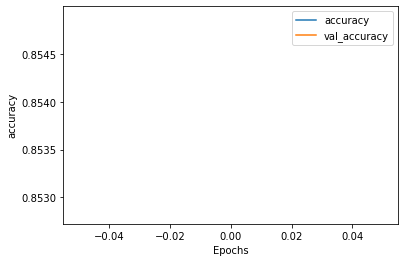

In [26]:
plot_graphs(history, 'accuracy')

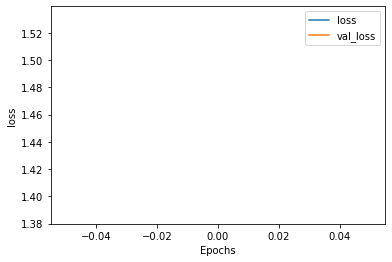

In [27]:
plot_graphs(history, 'loss')

In [28]:
char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']

In [ ]:
text = "남자친구 승진 선물로 뭐가 좋을까?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

In [32]:
outputs

[]

# **Load Weights**

In [30]:
def load_model_with_little_train() :
    EPOCH, BATCH_SIZE = 1, 64
    load_model = Transformer(**kargs)
    load_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=loss, metrics=[accuracy])
    history = load_model.fit([index_inputs[:BATCH_SIZE], index_outputs[:BATCH_SIZE]], index_targets[:BATCH_SIZE], batch_size=BATCH_SIZE, epochs=EPOCH)
    return load_model


model_name = f"weights_{kargs['num_layers']}layers_{kargs['d_model']}d_model_{kargs['num_heads']}num_heads_best.h5"
load_model = load_model_with_little_train()
load_model.load_weights(os.path.join(DATA_OUT_PATH, model_name))

1/1 [==============================] - 11s 11s/step - loss: 1.9870 - accuracy: 0.8012


In [38]:
char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']

text = "안녕"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = load_model.inference(test_index_inputs)
print(' '.join([idx2char[str(o)] for o in outputs]))

안녕하세요


In [39]:
text = "뭐하고 있어?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = load_model.inference(test_index_inputs)
print(' '.join([idx2char[str(o)] for o in outputs]))

저랑 놀아요


In [45]:
text = "뭐하고 놀까?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = load_model.inference(test_index_inputs)
print(' '.join([idx2char[str(o)] for o in outputs]))

저랑 놀아요


In [46]:
text = "음.. 그럼 카톡할까?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = load_model.inference(test_index_inputs)
print(' '.join([idx2char[str(o)] for o in outputs]))

충분히 힘들지 않았으면 좋겠어요


In [47]:
text = "난 안힘든데?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = load_model.inference(test_index_inputs)
print(' '.join([idx2char[str(o)] for o in outputs]))

나쁜 사람이 있을 것 같아요


In [48]:
text = "주변에 다 좋은 사람들 뿐인데?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = load_model.inference(test_index_inputs)
print(' '.join([idx2char[str(o)] for o in outputs]))

그렇게 이야기네요
